WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε, ν_]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
Sampling: [y_pred]


Output()

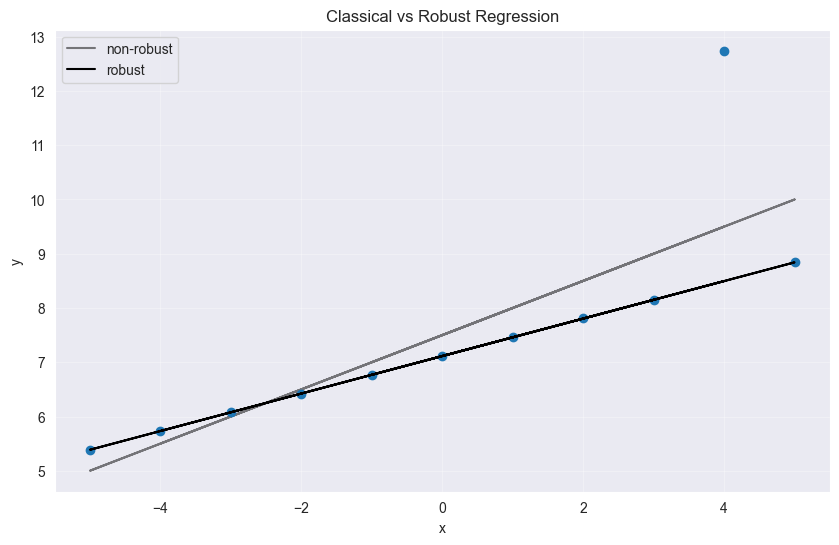

<Figure size 1200x600 with 0 Axes>

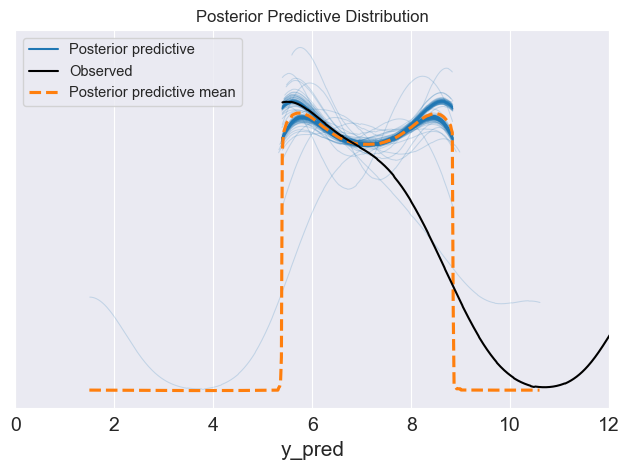

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc as pm
import seaborn as sns
import arviz as az
from scipy.stats import linregress

# Create Anscombe's quartet dataset with all four groups
anscombe = pd.DataFrame({
    'group': ['I']*11 + ['II']*11 + ['III']*11 + ['IV']*11,
    'x': [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5] * 4,
    'y': [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68,  # Group I
          9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74,   # Group II
          7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73,  # Group III
          7.91, 8.81, 8.04, 7.93, 8.89, 8.19, 7.53, 8.24, 8.01, 7.20, 6.85]   # Group IV
})

# Extract dataset III
x_3 = anscombe[anscombe.group == 'III']['x'].values
y_3 = anscombe[anscombe.group == 'III']['y'].values

# Center x_3
x_3 = x_3 - x_3.mean()

# Classical linear regression
beta_c, alpha_c = linregress(x_3, y_3)[:2]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot classical regression line
plt.plot(x_3, alpha_c + beta_c * x_3, 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')

# Bayesian robust regression with PyMC
with pm.Model() as model_t:
    # Priors
    α = pm.Normal('α', mu=y_3.mean(), sigma=1)
    β = pm.Normal('β', mu=0, sigma=1)
    ε = pm.HalfNormal('ε', 5)
    ν_ = pm.Exponential('ν_', 1/29)
    ν = pm.Deterministic('ν', ν_ + 1)
    
    # Likelihood
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3,
                        sigma=ε, nu=ν, observed=y_3)
    
    # Sample from the posterior
    idata_t = pm.sample(2000, return_inferencedata=True)
    
    # Generate posterior predictive samples
    posterior_pred = pm.sample_posterior_predictive(idata_t, extend_inferencedata=True)

# Extract posterior means
alpha_m = float(idata_t.posterior['α'].mean())
beta_m = float(idata_t.posterior['β'].mean())

# Plot robust regression line
plt.plot(x_3, alpha_m + beta_m * x_3, 'k', label='robust')

# Customize plot
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=2)
plt.title('Classical vs Robust Regression')
plt.grid(True, alpha=0.3)

# Create posterior predictive plot
plt.figure(figsize=(12, 6))
az.plot_ppc(idata_t, num_pp_samples=200, mean=True)
plt.xlim(0, 12)
plt.title('Posterior Predictive Distribution')

plt.tight_layout()
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 28 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β2, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

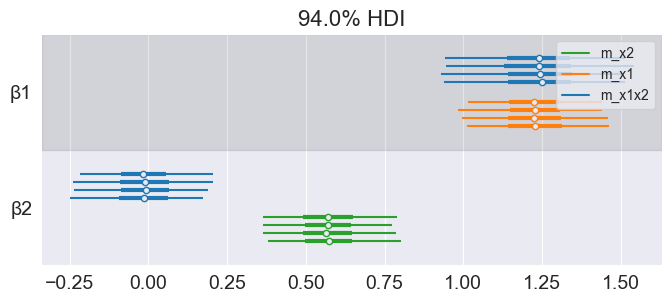

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import linregress


np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
# x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T


with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    µ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=µ, sigma=ϵ, observed=y)
    idata_x1x2 = pm.sample(2000, return_inferencedata=True)

with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    µ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=µ, sigma=ϵ, observed=y)
    idata_x1 = pm.sample(2000, return_inferencedata=True)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)
    µ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=µ, sigma=ϵ, observed=y)
    idata_x2 = pm.sample(2000, return_inferencedata=True)

az.plot_forest([idata_x1x2, idata_x1, idata_x2],
model_names=['m_x1x2', 'm_x1', 'm_x2'],
var_names=['β1', 'β2'],
combined=False, colors='cycle', figsize=(8, 3))


In [24]:
import pandas as pd
import numpy as np
import pymc as pm

# Read the CSV file
df = pd.read_csv('Prices.csv')

# Use 'Speed' and the logarithm of 'HardDrive' as predictors
X = df[['Speed', 'HardDrive']].values
X[:, 1] = np.log(X[:, 1])
y = df['Price'].values

premium_mask = df['Premium'] == 'yes'
non_premium_mask = ~premium_mask

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta1 * X[:, 0] + beta2 * X[:, 1]
    
    # Likelihood
    y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y)
    
    # Sample from the posterior
    idata = pm.sample(2000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


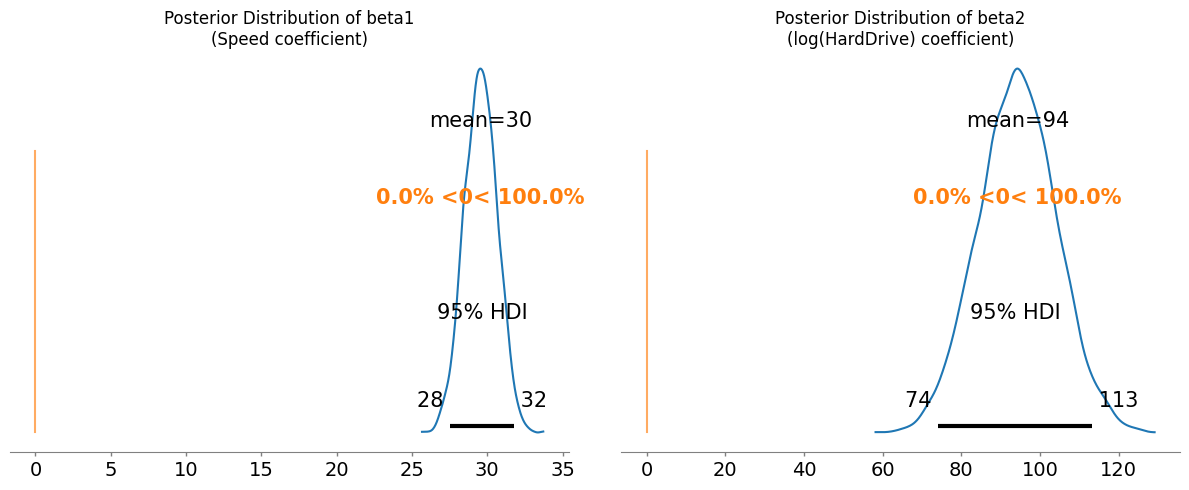


Numerical Summary:
------------------
95% HDI for beta1: [27.52, 31.80]
95% HDI for beta2: [74.12, 113.38]


In [42]:
import arviz as az
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot beta1
az.plot_posterior(idata, var_names=['beta1'], ax=ax1, hdi_prob=0.95, 
                 point_estimate='mean', ref_val=0)
ax1.set_title('Posterior Distribution of beta1\n(Speed coefficient)')

# Plot beta2
az.plot_posterior(idata, var_names=['beta2'], ax=ax2, hdi_prob=0.95, 
                 point_estimate='mean', ref_val=0)
ax2.set_title('Posterior Distribution of beta2\n(log(HardDrive) coefficient)')

# Adjust layout
plt.tight_layout()
plt.show()

# Print the numerical values
print("\nNumerical Summary:")
print("------------------")
hdi_beta1 = az.hdi(idata, var_names=['beta1'], hdi_prob=0.95)
hdi_beta2 = az.hdi(idata, var_names=['beta2'], hdi_prob=0.95)
print(f"95% HDI for beta1: [{hdi_beta1['beta1'][0]:.2f}, {hdi_beta1['beta1'][1]:.2f}]")
print(f"95% HDI for beta2: [{hdi_beta2['beta2'][0]:.2f}, {hdi_beta2['beta2'][1]:.2f}]")

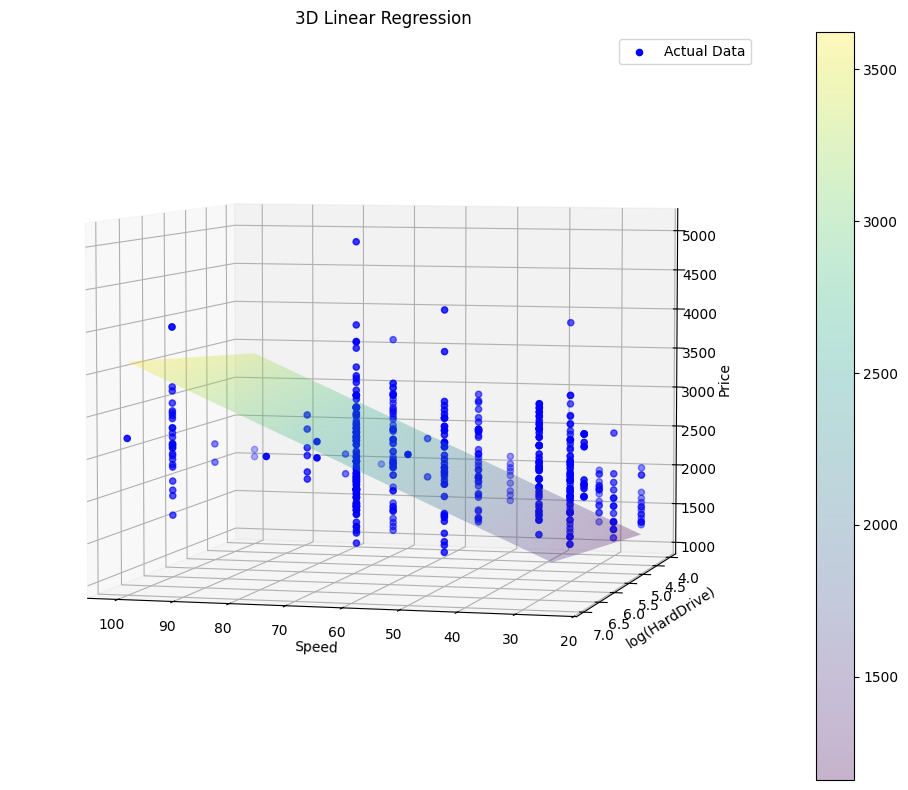

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get the mean values of the parameters
alpha_mean = float(idata.posterior['alpha'].mean())
beta1_mean = float(idata.posterior['beta1'].mean())
beta2_mean = float(idata.posterior['beta2'].mean())

# Create a meshgrid for the surface plot
speed_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
hd_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
speed_mesh, hd_mesh = np.meshgrid(speed_range, hd_range)

# Calculate predicted prices for the meshgrid
z = alpha_mean + beta1_mean * speed_mesh + beta2_mean * hd_mesh

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the actual data points
ax.scatter(X[:, 0], X[:, 1], y, c='blue', marker='o', label='Actual Data')

# Plot the regression plane
surface = ax.plot_surface(speed_mesh, hd_mesh, z, alpha=0.3, cmap='viridis')

# Add labels and title
ax.set_xlabel('Speed')
ax.set_ylabel('log(HardDrive)')
ax.set_zlabel('Price')
ax.set_title('3D Linear Regression')

# Add a color bar
fig.colorbar(surface)

# Add legend
ax.legend()

# Adjust the viewing angle for better visualization
ax.view_init(elev=5, azim=105)

plt.tight_layout()
plt.show()

In [43]:
import numpy as np
import arviz as az

def compute_intervals(idata, speed, hd_size, n_draws=5000):
    """
    Compute both parameter uncertainty and predictive intervals
    
    Parameters:
    idata: InferenceData object from PyMC sampling
    speed: CPU speed in MHz
    hd_size: Hard drive size in MB (will be log-transformed)
    n_draws: Number of draws to simulate
    
    Returns:
    tuple: (parameter_hdi, predictive_hdi)
    """
    # Extract posterior samples
    posterior = idata.posterior
    
    # Get all chains/draws for our parameters
    alpha = posterior.alpha.values.flatten()
    beta1 = posterior.beta1.values.flatten()
    beta2 = posterior.beta2.values.flatten()
    epsilon = posterior.epsilon.values.flatten()
    
    # Log transform HD size
    log_hd = np.log(hd_size)
    
    # Calculate mu (expected value) for all posterior samples
    mu = alpha + beta1 * speed + beta2 * log_hd
    
    # Point 4: HDI of expected value (parameter uncertainty only)
    param_hdi = az.hdi(mu, hdi_prob=0.90)
    
    # Point 5: Predictive HDI (including observation noise)
    # Generate new observations for each posterior sample
    predictions = np.random.normal(loc=mu, scale=epsilon, size=len(mu))
    pred_hdi = az.hdi(predictions, hdi_prob=0.90)
    
    return param_hdi, pred_hdi

# Calculate both intervals for the given values
speed = 33  # MHz
hd_size = 540  # MB

param_hdi, pred_hdi = compute_intervals(idata, speed, hd_size)

print("Point 4 - 90% HDI for expected price (parameter uncertainty):")
print(f"[${param_hdi[0]:.2f}, ${param_hdi[1]:.2f}]")

print("\nPoint 5 - 90% HDI for predicted price (including observation noise):")
print(f"[${pred_hdi[0]:.2f}, ${pred_hdi[1]:.2f}]")

Point 4 - 90% HDI for expected price (parameter uncertainty):
[$1525.61, $1648.40]

Point 5 - 90% HDI for predicted price (including observation noise):
[$385.69, $2723.92]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, epsilon]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


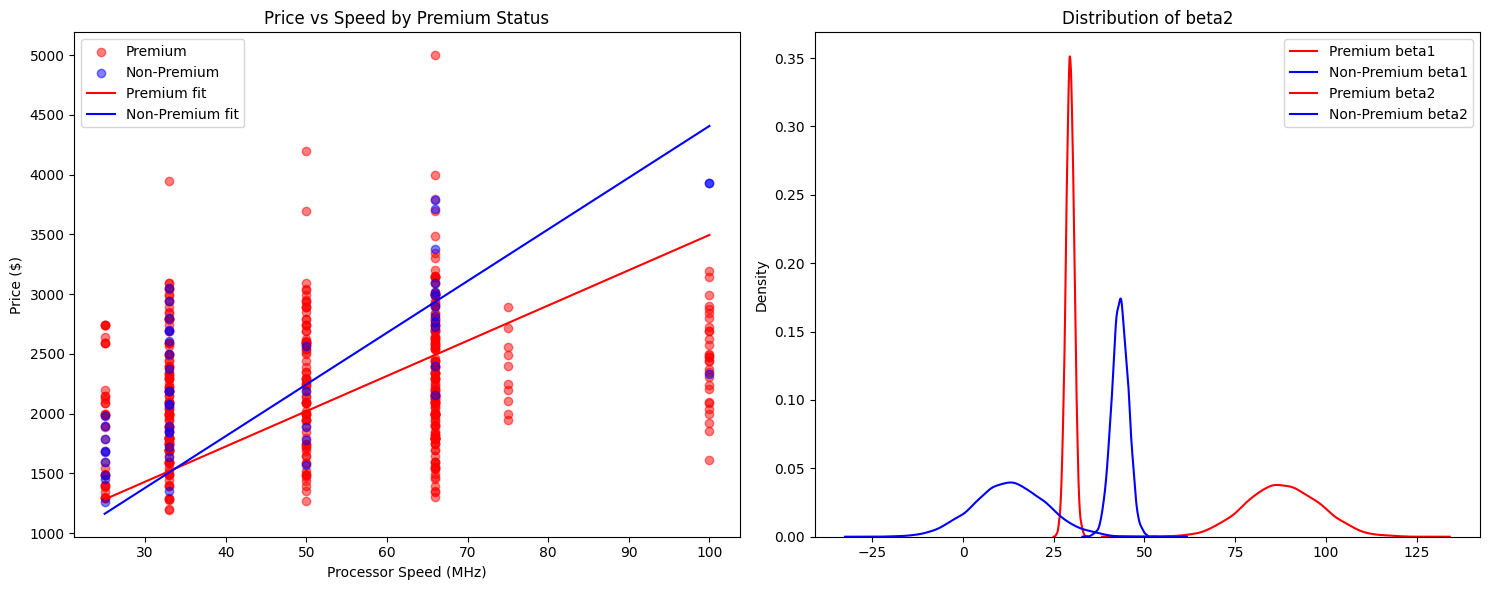

At median values, premium computers are $-223.81 more expensive


In [47]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your dataframe with a 'Premium' column (True/False or 1/0)
# Let's create two models and compare them

def create_and_sample_model(X, y, premium_filter):
    """Create and sample a model for either premium or non-premium computers"""
    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta1 = pm.Normal('beta1', mu=0, sigma=10)
        beta2 = pm.Normal('beta2', mu=0, sigma=10)
        epsilon = pm.HalfCauchy('epsilon', 5)
        
        mu = alpha + beta1 * X[premium_filter, 0] + beta2 * X[premium_filter, 1]
        
        y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y[premium_filter])
        
        return pm.sample(2000, return_inferencedata=True)

# Split data into premium and non-premium
premium_mask = df['Premium'] == 'yes'
non_premium_mask = ~premium_mask

# Sample from both models
premium_trace = create_and_sample_model(X, y, premium_mask)
non_premium_trace = create_and_sample_model(X, y, non_premium_mask)

# Create a visualization to compare the models
def plot_model_comparison():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Generate a range of values for visualization
    speed_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    hd_range = np.log(np.median(np.exp(X[:, 1])))  # Use median HD size
    
    # Extract parameters for both models
    def get_predictions(trace):
        alpha = trace.posterior.alpha.values.mean()
        beta1 = trace.posterior.beta1.values.mean()
        beta2 = trace.posterior.beta2.values.mean()
        return alpha + beta1 * speed_range + beta2 * hd_range
    
    premium_pred = get_predictions(premium_trace)
    non_premium_pred = get_predictions(non_premium_trace)
    
    # Plot actual data points
    ax1.scatter(X[premium_mask, 0], y[premium_mask], alpha=0.5, label='Premium', c='red')
    ax1.scatter(X[non_premium_mask, 0], y[non_premium_mask], alpha=0.5, label='Non-Premium', c='blue')
    
    # Plot regression lines
    ax1.plot(speed_range, premium_pred, 'r-', label='Premium fit')
    ax1.plot(speed_range, non_premium_pred, 'b-', label='Non-Premium fit')
    ax1.set_xlabel('Processor Speed (MHz)')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.set_title('Price vs Speed by Premium Status')
    
    # Plot parameter distributions
    def plot_param_dists(ax, param_name):
        premium_param = premium_trace.posterior[param_name].values.flatten()
        non_premium_param = non_premium_trace.posterior[param_name].values.flatten()
        
        sns.kdeplot(data=premium_param, ax=ax, label=f'Premium {param_name}', color='red')
        sns.kdeplot(data=non_premium_param, ax=ax, label=f'Non-Premium {param_name}', color='blue')
        ax.set_title(f'Distribution of {param_name}')
    
    plot_param_dists(ax2, 'beta1')  # Compare speed coefficients
    plot_param_dists(ax2, 'beta2')  # Compare HD coefficients
    
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Create and display the comparison plot
fig = plot_model_comparison()
plt.show()

# Calculate the price difference at median values
def calculate_price_difference():
    median_speed = np.median(X[:, 0])
    median_hd = np.median(X[:, 1])
    
    def get_median_prediction(trace):
        alpha = trace.posterior.alpha.values.mean()
        beta1 = trace.posterior.beta1.values.mean()
        beta2 = trace.posterior.beta2.values.mean()
        return alpha + beta1 * median_speed + beta2 * median_hd
    
    premium_price = get_median_prediction(premium_trace)
    non_premium_price = get_median_prediction(non_premium_trace)
    
    return premium_price - non_premium_price

price_diff = calculate_price_difference()
print(f"At median values, premium computers are ${price_diff:.2f} more expensive")